In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pickle

In [2]:
conn2 = pyodbc.connect('Driver={SQL Server};'
                                'Server=finesserds.cahwy5tcsaqu.us-east-1.rds.amazonaws.com,1433;'
                                'Database=Youtube_data;'
                                'uid=admin;pwd=gloryboy')
print ("Connected")
cursor = conn2.cursor()

Connected


In [3]:
query = '''
SELECT *
FROM modeling_data3
WHERE months_since_upload <= 2
'''

In [4]:
df = pd.read_sql_query(query, con= conn2)

In [5]:
df.head(3)

,video_id,comedian,year,year_month,months_since_upload,video_duration,view_count,like_count,day_of_week,weekend_weekday,monthly_videos_count
0,--RBGALW1GE,Broda Shaggi,2022,2022-04,0,5,137624,8683,Tuesday,Weekday,2
1,-b2M37ez-os,Mr macaroni,2022,2022-03,1,5,429162,9828,Tuesday,Weekday,11
2,-UZ53Xx2O-c,Broda Shaggi,2022,2022-04,0,4,121829,7678,Tuesday,Weekday,2


In [6]:
df['year'] = df['year'].astype(str)

In [7]:
comedian = df['comedian'].unique()
gender = ['M', 'M', 'F', 'M']
df['gender'] = df['comedian'].map(dict(zip(comedian, gender)))

In [8]:
df1 = df[['comedian', 'gender', 'year', 'months_since_upload', 'video_duration',
       'view_count', 'weekend_weekday', 'monthly_videos_count','like_count']]

In [9]:
cat_columns = ['comedian', 'gender', 'year','weekend_weekday']

In [10]:
features = df1.columns.drop('like_count')
X = df1[list(features)]
y = df1['like_count']

In [11]:
from sklearn.metrics import mean_absolute_error as MAE

In [12]:
encoder =  pickle.load(open('Fitted_OneHotencoder.pkl', 'rb'))

In [13]:
def encode_new_data(new_data_df):
    cat_ohe_new = encoder.transform(new_data_df[cat_columns])
    ohe_new_data_df = pd.DataFrame(cat_ohe_new, columns = encoder.get_feature_names_out(input_features = cat_columns))
    
    new_data_df.reset_index(inplace= True)
    new_data_df.drop('index', axis= 1, inplace= True)
    
    new_data_df_encoded = pd.concat([new_data_df, ohe_new_data_df], axis=1).drop(columns = cat_columns, axis=1)
    return new_data_df_encoded

In [14]:
loaded_model = pickle.load(open('RF_model.pkl', 'rb'))

In [15]:
y_pred = loaded_model.predict(encode_new_data(X))
y_pred = np.round(y_pred)
preds = pd.DataFrame(data=y_pred, columns= ['likes_prediction'])
preds['likes_prediction'] = preds['likes_prediction'].apply(lambda x: int(x))
#preds.to_csv('predictions.csv', index = False)
#print('Prediction completed')

C:\Users\tuneG\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
mae_test = MAE(y, y_pred)
print(mae_test)


1839.75


In [17]:
final_df = df[['video_id', 'comedian', 'gender', 'year', 'year_month', 'months_since_upload',
       'video_duration', 'view_count', 'day_of_week',
       'weekend_weekday', 'monthly_videos_count', 'like_count']]

In [18]:
final_df = pd.concat([final_df, preds], axis = 1)

In [19]:
final_df

,video_id,comedian,gender,year,year_month,months_since_upload,video_duration,view_count,day_of_week,weekend_weekday,monthly_videos_count,like_count,likes_prediction
0,--RBGALW1GE,Broda Shaggi,M,2022,2022-04,0,5,137624,Tuesday,Weekday,2,8683,5996
1,-b2M37ez-os,Mr macaroni,M,2022,2022-03,1,5,429162,Tuesday,Weekday,11,9828,12759
2,-UZ53Xx2O-c,Broda Shaggi,M,2022,2022-04,0,4,121829,Tuesday,Weekday,2,7678,5506
3,_SsQYmttPvY,Broda Shaggi,M,2022,2022-02,2,1,258522,Friday,Weekday,7,11713,9442
4,_u_nE2mBGFc,Mr macaroni,M,2022,2022-02,2,10,542127,Saturday,Weekend,12,16819,13491
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,xW5LtpmzmY0,Mc_lively,M,2022,2022-02,2,6,90494,Thursday,Weekday,8,4065,4547
88,yeG10iI3YuQ,Taaooma,F,2022,2022-02,2,1,90937,Saturday,Weekend,12,3752,5660
89,yNPP07Cidro,Mr macaroni,M,2022,2022-03,1,5,418634,Sunday,Weekend,11,13092,12502
90,Z9GLv2ZMAKs,Mc_lively,M,2022,2022-03,1,4,76909,Thursday,Weekday,8,2897,3961


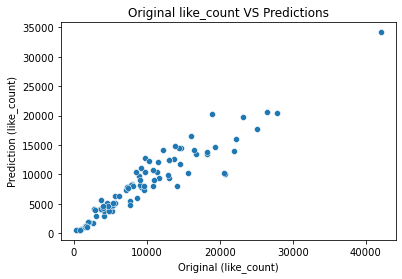

In [20]:
sns.scatterplot(data = final_df, x = 'like_count', y = 'likes_prediction')
plt.xlabel('Original (like_count)')
plt.ylabel('Prediction (like_count)')
plt.title('Original like_count VS Predictions')
plt.show()

In [21]:
final_df.columns

Index(['video_id', 'comedian', 'gender', 'year', 'year_month',
       'months_since_upload', 'video_duration', 'view_count', 'day_of_week',
       'weekend_weekday', 'monthly_videos_count', 'like_count',
       'likes_prediction'],
      dtype='object')

In [22]:
# query = '''
#     CREATE TABLE predictions (
#         video_id varchar(max) NULL,
#         comedian varchar(max) NULL,
#         gender varchar(3) NULL,
#         year varchar(max) NULL,
#         year_month varchar(max) NULL,
#         months_since_upload int NULL,
#         video_duration int NULL,
#         view_count int NULL,
#         day_of_week varchar(max) NULL,
#         weekend_weekday varchar(max) NULL, 
#         monthly_videos_count int NULL, 
#         like_count int NULL,
#         likes_prediction int NULL)
#     '''

In [23]:
# cursor.execute(query)
# conn2.commit()

In [24]:
# def insert_new_data_to_table(video_id, comedian, gender, year, year_month, months_since_upload,
#                              video_duration, view_count, day_of_week, weekend_weekday, monthly_videos_count,
#                              like_count, likes_prediction):
#     query = '''
#             INSERT INTO predictions (video_id, comedian, gender, year, year_month, months_since_upload,
#                              video_duration, view_count, day_of_week, weekend_weekday, monthly_videos_count,
#                              like_count, likes_prediction) 
#             VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?)
#     '''
#     row_values_to_insert = (video_id, comedian, gender, year, year_month, months_since_upload,
#                              video_duration, view_count, day_of_week, weekend_weekday, monthly_videos_count,
#                              like_count, likes_prediction)
    
#     cursor.execute(query, row_values_to_insert)

In [25]:
# for idx, row in final_df.iterrows():
#     insert_new_data_to_table(row['video_id'], row['comedian'], row['gender'], row['year'], row['year_month'],
#                        row['months_since_upload'], row['video_duration'], row['view_count'], row['day_of_week'],
#                        row['weekend_weekday'], row['monthly_videos_count'], row['like_count'], row['likes_prediction'])

In [26]:
#conn2.commit()

In [27]:
def check_if_video_exists(video_id):
    query = '''
       SELECT *
       FROM predictions
       WHERE video_id = ?
    '''
    row = cursor.execute(query, (video_id,))
    if row:
        return row.fetchone()
    else:
        return None

In [28]:
def update_row(view_count, like_count, likes_prediction, video_id):
    query = '''
            UPDATE predictions
            SET 
                view_count = ?,
                like_count = ?,
                likes_prediction = ?
            WHERE video_id = ?
    '''
    vars_to_update = (view_count, like_count, likes_prediction, video_id)
    cursor.execute(query, vars_to_update)

In [29]:
def update_db(df):
    temp_df = pd.DataFrame(columns = ['video_id', 'comedian', 'gender', 'year', 'year_month', 'months_since_upload',
                    'video_duration', 'view_count', 'day_of_week', 'weekend_weekday', 'monthly_videos_count', 'like_count',
                    'likes_prediction'])
    for i, row in df.iterrows():
        if check_if_video_exists(row['video_id']):
            update_row(row['view_count'], row['like_count'], row['likes_prediction'], row['video_id'])
        else:
            temp_df = temp_df.append(row)
            
    return temp_df


In [30]:
new_data_dff = update_db(final_df)
print('Updated existing videos')

Updated existing videos


In [31]:
if new_data_dff.empty:
    print('No new data to add')
    
else:
    for idx, row in new_data_dff.iterrows():
        insert_new_data_to_table(row['video_id'], row['comedian'], row['gender'], row['year'], row['year_month'],
                           row['months_since_upload'], row['video_duration'], row['view_count'], row['day_of_week'],
                           row['weekend_weekday'], row['monthly_videos_count'], row['like_count'], row['likes_prediction'])
    print('Added new data')

No new data to add


In [32]:
conn2.commit()